### Initial Setup 🧑‍💻

Setup the project, import the required dependencies

> Make sure the `lib` directory exists and include: `keras_video`, `i3d_inception.py`

In [29]:
import glob
import os
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import lib.helpers as helpers

from lib.keras_video import VideoFrameGenerator
from lib.i3d_inception import Inception_Inflated3d

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

from tensorflow.keras.layers import Dense, GlobalAveragePooling3D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython import get_ipython

get_ipython().run_line_magic("matplotlib", "inline")
warnings.filterwarnings("ignore")

### Pre-Defining Global Variable

Setup global variable to use in the entire file

In [2]:
DS = os.path.sep
DATASET_DIR = "dataset"

BATCH_SIZE = 2
NB_COLOR_CHANNELS = 3
NB_FRAMES = 30
RESOLUTION = (224, 224)

### Generating Class Names & Glob Pattern

Load all the file paths at the DATASET_DIR to generate the class names. Also, define glob pattern to get the dataset

In [3]:
class_names = helpers.get_generated_class_names(DATASET_DIR)
glob_pattern = helpers.get_generated_glob_pattern(DATASET_DIR)

### Dataset Setup

Setup the dataset with `keras_video.VideoFrameGenerator` to do the dataset extraction

In [4]:
train_dataset_generator = VideoFrameGenerator(
    batch_size=BATCH_SIZE,
    classes=class_names,
    glob_pattern=glob_pattern,
    nb_channel=NB_COLOR_CHANNELS,
    nb_frames=NB_FRAMES,
    seed=42,
    split_test=.20,
    split_val=.20,
    target_shape=RESOLUTION,
    transformation=None,
    use_frame_cache=False
)

test_dataset_generator = train_dataset_generator.get_test_generator()
valid_dataset_generator = train_dataset_generator.get_validation_generator()

class Agem_Kanan, validation count: 24, test count: 19, train count: 77
class Agem_Kiri, validation count: 24, test count: 19, train count: 77
class Ngegol, validation count: 24, test count: 19, train count: 77
Total data: 3 classes for 231 files for train
Total data: 3 classes for 57 files for test
Total data: 3 classes for 72 files for validation


In [ ]:
input_shape = (NB_FRAMES,) + RESOLUTION + (NB_COLOR_CHANNELS,)

### Prepare `i3d` Layer

Preparing the configuration to create the `i3d` layer to add to the created model

In [5]:
i3d_layer = Inception_Inflated3d(
    classes=3,
    include_top=False,
    input_shape=input_shape,
    weights="rgb_kinetics_only"
)

i3d_layer.trainable = False

### Model Creation

Creating `Sequential` model and add `i3d` and some other layers to the created model

In [6]:
model = Sequential()

# classification layer
model.add(i3d_layer)
model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(int(len(class_names)), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 i3d_inception (Functional)  (None, 3, 1, 1, 1024)     12294544  
                                                                 
 global_average_pooling3d (G  (None, 1024)             0         
 lobalAveragePooling3D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 12,820,883
Trainable params: 526,339
Non-trainable params: 12,294,544
______________________________________

### Compiling & Fitting Setup

Some setup configuration for compiling and fitting the model. Defining epochs, earlystopping, checkpoint, and callbacks.

In [7]:
model_epochs = 5 # TODO Change the epochs count when needed
model_earlystopping = EarlyStopping(monitor="loss", patience=10)
model_checkpoint = ModelCheckpoint(
    filepath="checkpoint/i3d.h5",
    mode="max",
    monitor="val_acc",
    save_best_only=True,
    verbose=1
)

model_callbacks = [model_earlystopping, model_checkpoint]

### Model Compile

Compiling model with pre-defined configuration

In [8]:
model.compile(
    loss="categorical_crossentropy", 
    metrics=["acc"],
    optimizer="adam"
)

### Model Training/Fitting

Fit the model with real dataset with defined epochs and callbacks

In [9]:
model_history = model.fit(
    train_dataset_generator,
    callbacks=model_callbacks,
    epochs=model_epochs,
    validation_data=valid_dataset_generator
)

Epoch 1/5
115/115 [==============================] - ETA: 0s - loss: 1.2846 - acc: 0.3609
Epoch 1: val_acc improved from -inf to 0.59722, saving model to checkpoint/i3d.h5
115/115 [==============================] - 58s 443ms/step - loss: 1.2846 - acc: 0.3609 - val_loss: 0.9332 - val_acc: 0.5972
Epoch 2/5
115/115 [==============================] - ETA: 0s - loss: 0.9268 - acc: 0.5304
Epoch 2: val_acc did not improve from 0.59722
115/115 [==============================] - 48s 413ms/step - loss: 0.9268 - acc: 0.5304 - val_loss: 0.8467 - val_acc: 0.5417
Epoch 3/5
115/115 [==============================] - ETA: 0s - loss: 0.8156 - acc: 0.5826
Epoch 3: val_acc improved from 0.59722 to 0.61111, saving model to checkpoint/i3d.h5
115/115 [==============================] - 48s 418ms/step - loss: 0.8156 - acc: 0.5826 - val_loss: 0.7837 - val_acc: 0.6111
Epoch 4/5
115/115 [==============================] - ETA: 0s - loss: 0.8038 - acc: 0.5696
Epoch 4: val_acc did not improve from 0.61111
115/115 [

### Save Model

Saving model file into `model` directory

In [10]:
model.save("model/dance/i3d-5e.h5")

### Acc Visualization

Visualizing acc data with Matplotlib graph

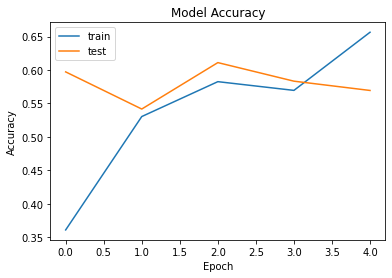

In [11]:
helpers.get_visualized_graph(
  plots=[model_history.history["acc"], model_history.history["val_acc"]],
  title="Model Accuracy",
  x_label="Epoch",
  y_label="Accuracy",
  legend=["train", "test"]
).show()

### Loss Visualization

Visualizing loss data with Matplotlib graph

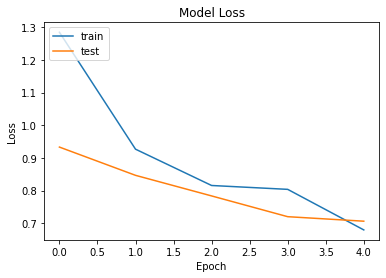

In [12]:
helpers.get_visualized_graph(
  plots=[model_history.history["loss"], model_history.history["val_loss"]],
  title="Model Loss",
  x_label="Epoch",
  y_label="Loss",
  legend=["train", "test"]
).show()

### Exporting CSV From Model

Exporting data to `.csv` file from the model history via Pandas library

In [14]:
model_history_dataframe = pd.DataFrame(model_history.history)
model_history_fpath = "history/dance/i3d-5e.csv"

with open(model_history_fpath, mode="w") as history_file:
    model_history_dataframe.to_csv(history_file)

### Model Evaluation

Evaluating model with test dataset

In [15]:
model.evaluate(test_dataset_generator)

28/28 [==============================] - 10s 331ms/step - loss: 0.7150 - acc: 0.6071


[0.7150302529335022, 0.6071428656578064]

### Populate Y Data

Populating Y's `prediction` and `test` data with test dataset

In [16]:
y_prediction_max, y_true = helpers.get_populated_y_data(
    batch_size=BATCH_SIZE,
    generator=test_dataset_generator,
    model=model
)

1/1 [==============================] - 0s 85ms/step


### Score Visualization

Visualizing some of calculated model score types, like `accuracy`, `precision`, `recall`, and `f1` score

In [18]:
score_accuracy, score_precision, score_recall, score_f1 = helpers.get_calculated_score(y_true, y_prediction_max)

print(f"Accuracy Score\t: {np.round(score_accuracy, 3)}")
print(f"Precision Score\t: {np.round(score_precision, 3)}")
print(f"Recall Score\t: {np.round(score_recall, 3)}")
print(f"F1 Score\t: {np.round(score_f1, 3)}")

Accuracy Score	: 0.607
Precision Score	: 0.652
Recall Score	: 0.611
F1 Score	: 0.581


### Classification Report Visualization

Visualizing classification report of test dataset

In [19]:
test_class_names = test_dataset_generator.classes

print(classification_report(
    y_true,
    y_prediction_max,
    target_names=test_class_names
))

              precision    recall  f1-score   support

  Agem_Kanan       0.46      0.84      0.59        19
   Agem_Kiri       0.50      0.16      0.24        19
      Ngegol       1.00      0.83      0.91        18

    accuracy                           0.61        56
   macro avg       0.65      0.61      0.58        56
weighted avg       0.65      0.61      0.57        56



### Confusion Matrix Visualization

Visualizing confusion matrix with heatmap table

<AxesSubplot:>

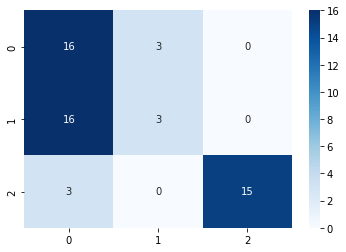

In [20]:
confusion_matrix_result = confusion_matrix(y_true, y_prediction_max)

sns.heatmap(
    confusion_matrix_result,
    annot=True,
    cmap="Blues"
)

### AUC Score Visualization

Visualization of AUC score calculated with FPR and TPR

In [30]:
fpr, tpr, _ = roc_curve(y_true, y_prediction_max, pos_label=6)
score_auc = auc(fpr, tpr)

print(f"AUC Score\t: {np.round(score_auc, 3)}")

AUC Score	: nan


### True/False Positive Rate Visualization

Visualizing `true`/`false` rate with Matplotlib graph calculated from FPR and TPR

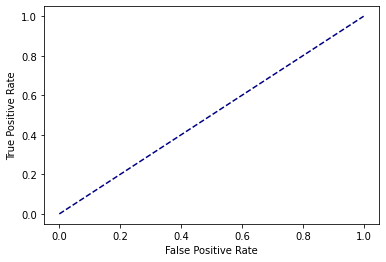

In [31]:
plt.plot(fpr, tpr, marker=".")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.show()

### Visualizing Checkpoint Model

Visualizing all the score/calculated score from the checkpoint model

In [32]:
from tensorflow.keras.models import load_model

checkpoint_model = load_model("checkpoint/i3d.h5")
checkpoint_model.evaluate(test_dataset_generator)

28/28 [==============================] - 11s 325ms/step - loss: 0.8536 - acc: 0.5357


[0.8535967469215393, 0.5357142686843872]

### Populate Y Data

Populating checkpoint model Y's `prediction` and `test` data with test dataset

In [33]:
y_prediction_max, y_true = helpers.get_populated_y_data(
    batch_size=BATCH_SIZE,
    generator=test_dataset_generator,
    model=model
)

1/1 [==============================] - 0s 82ms/step


### Score Visualization

Visualizing some of calculated checkpoint model score types, like `accuracy`, `precision`, `recall`, and `f1` score

In [34]:
score_accuracy, score_precision, score_recall, score_f1 = helpers.get_calculated_score(y_true, y_prediction_max)

print(f"Accuracy Score\t: {np.round(score_accuracy, 3)}")
print(f"Precision Score\t: {np.round(score_precision, 3)}")
print(f"Recall Score\t: {np.round(score_recall, 3)}")
print(f"F1 Score\t: {np.round(score_f1, 3)}")

Accuracy Score	: 0.536
Precision Score	: 0.357
Recall Score	: 0.526
F1 Score	: 0.423


### Classification Report Visualization

Visualizing checkpoint model classification report of test dataset

In [35]:
test_class_names = test_dataset_generator.classes

print(classification_report(
    y_true,
    y_prediction_max,
    target_names=test_class_names
))

              precision    recall  f1-score   support

  Agem_Kanan       0.48      0.58      0.52        19
   Agem_Kiri       0.00      0.00      0.00        18
      Ngegol       0.59      1.00      0.75        19

    accuracy                           0.54        56
   macro avg       0.36      0.53      0.42        56
weighted avg       0.36      0.54      0.43        56



### Confusion Matrix Visualization

Visualizing checkpoint model confusion matrix with heatmap table

<AxesSubplot:>

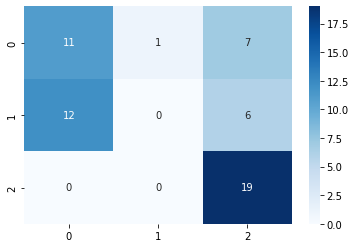

In [36]:
confusion_matrix_result = confusion_matrix(y_true, y_prediction_max)

sns.heatmap(
    confusion_matrix_result,
    annot=True,
    cmap="Blues"
)

### AUC Score Visualization

Visualization of checkpoint model AUC score calculated with FPR and TPR

In [37]:
fpr, tpr, _ = roc_curve(y_true, y_prediction_max, pos_label=6)
score_auc = auc(fpr, tpr)

print(f"AUC Score\t: {np.round(score_auc, 3)}")

AUC Score	: nan


### True/False Positive Rate Visualization

Visualizing checkpoint model `true`/`false` rate with Matplotlib graph calculated from FPR and TPR

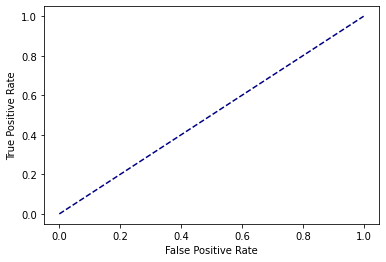

In [38]:
plt.plot(fpr, tpr, marker=".")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.show()